# Hyperparameter tuning for XGBoost in SageMaker

Uses the  'used car prices' dataset to train a SageMaker XGBoost model capable of predicting the MSRP (Manufacturer's Suggested Retail Price). Deploys an unoptimised model and collects Key Performance Indicators (KPIs). Utilises SageMaker Hyperparameter Tuning Jobs to perform hyperparameter optimisation. Deploys the optimised model and collects Key Performance Indicators (KPIs).

- Steps:
    - Load the dataset
    - Perform Exploratory Data Analaysis (EDA)
    - Perform Data Visualisation
    - Split the data into training, validation and testing datasets
    - Prepare the data for SageMaker
    - Train an XG-Boost model using SageMaker
    - Deploy the unoptimised model and obtain KPI's
    - Perform Hyperparameter Tuning
    - Deploy the optimised model and obtain KPI's

## Import dependencies

In [154]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import sagemaker
import boto3
from sagemaker import Session
import os
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.analytics import HyperparameterTuningJobAnalytics

## 1. Load the dataset

In [155]:
# import the csv files using pandas 
car_df = pd.read_csv('data/used_car_price.csv')
car_df

,Make,Model,Type,Origin,DriveTrain,MSRP,EngineSize,Cylinders,Horsepower,MPG_City,MPG_Highway,Weight,Wheelbase,Length
0,Acura,MDX,SUV,Asia,All,36945,3.5,6,265,17,23,4451,106,189
1,Acura,RSX Type S 2dr,Sedan,Asia,Front,23820,2.0,4,200,24,31,2778,101,172
2,Acura,TSX 4dr,Sedan,Asia,Front,26990,2.4,4,200,22,29,3230,105,183
3,Acura,TL 4dr,Sedan,Asia,Front,33195,3.2,6,270,20,28,3575,108,186
4,Acura,3.5 RL 4dr,Sedan,Asia,Front,43755,3.5,6,225,18,24,3880,115,197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423,Volvo,C70 LPT convertible 2dr,Sedan,Europe,Front,40565,2.4,5,197,21,28,3450,105,186
424,Volvo,C70 HPT convertible 2dr,Sedan,Europe,Front,42565,2.3,5,242,20,26,3450,105,186
425,Volvo,S80 T6 4dr,Sedan,Europe,Front,45210,2.9,6,268,19,26,3653,110,190
426,Volvo,V40,Wagon,Europe,Front,26135,1.9,4,170,22,29,2822,101,180


## 2. Perform Exploratory Data Analaysis (EDA)

In [156]:
# view first 5 rows
car_df.head(5)

,Make,Model,Type,Origin,DriveTrain,MSRP,EngineSize,Cylinders,Horsepower,MPG_City,MPG_Highway,Weight,Wheelbase,Length
0,Acura,MDX,SUV,Asia,All,36945,3.5,6,265,17,23,4451,106,189
1,Acura,RSX Type S 2dr,Sedan,Asia,Front,23820,2.0,4,200,24,31,2778,101,172
2,Acura,TSX 4dr,Sedan,Asia,Front,26990,2.4,4,200,22,29,3230,105,183
3,Acura,TL 4dr,Sedan,Asia,Front,33195,3.2,6,270,20,28,3575,108,186
4,Acura,3.5 RL 4dr,Sedan,Asia,Front,43755,3.5,6,225,18,24,3880,115,197


In [157]:
# view last 5 rows
car_df.tail(5)

,Make,Model,Type,Origin,DriveTrain,MSRP,EngineSize,Cylinders,Horsepower,MPG_City,MPG_Highway,Weight,Wheelbase,Length
423,Volvo,C70 LPT convertible 2dr,Sedan,Europe,Front,40565,2.4,5,197,21,28,3450,105,186
424,Volvo,C70 HPT convertible 2dr,Sedan,Europe,Front,42565,2.3,5,242,20,26,3450,105,186
425,Volvo,S80 T6 4dr,Sedan,Europe,Front,45210,2.9,6,268,19,26,3653,110,190
426,Volvo,V40,Wagon,Europe,Front,26135,1.9,4,170,22,29,2822,101,180
427,Volvo,XC70,Wagon,Europe,All,35145,2.5,5,208,20,27,3823,109,186


In [158]:
# show general descriptive statistics
car_df.describe()

,MSRP,EngineSize,Cylinders,Horsepower,MPG_City,MPG_Highway,Weight,Wheelbase,Length
count,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000,428.000000
mean,32774.855140,3.196729,5.799065,215.885514,20.060748,26.843458,3577.953271,108.154206,186.362150
std,19431.716674,1.108595,1.559679,71.836032,5.238218,5.741201,758.983215,8.311813,14.357991
min,10280.000000,1.300000,3.000000,73.000000,10.000000,12.000000,1850.000000,89.000000,143.000000
25%,20334.250000,2.375000,4.000000,165.000000,17.000000,24.000000,3104.000000,103.000000,178.000000
50%,27635.000000,3.000000,6.000000,210.000000,19.000000,26.000000,3474.500000,107.000000,187.000000
75%,39205.000000,3.900000,6.000000,255.000000,21.250000,29.000000,3977.750000,112.000000,194.000000
max,192465.000000,8.300000,12.000000,500.000000,60.000000,66.000000,7190.000000,144.000000,238.000000


In [159]:
# show column data type info
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 428 entries, 0 to 427
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Make         428 non-null    object 
 1   Model        428 non-null    object 
 2   Type         428 non-null    object 
 3   Origin       428 non-null    object 
 4   DriveTrain   428 non-null    object 
 5   MSRP         428 non-null    int64  
 6   EngineSize   428 non-null    float64
 7   Cylinders    428 non-null    int64  
 8   Horsepower   428 non-null    int64  
 9   MPG_City     428 non-null    int64  
 10  MPG_Highway  428 non-null    int64  
 11  Weight       428 non-null    int64  
 12  Wheelbase    428 non-null    int64  
 13  Length       428 non-null    int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 46.9+ KB


In [160]:
# show count unique entries for each column
car_df.nunique()

Make            38
Model          425
Type             6
Origin           3
DriveTrain       3
MSRP           410
EngineSize      43
Cylinders        7
Horsepower     110
MPG_City        28
MPG_Highway     33
Weight         348
Wheelbase       40
Length          67
dtype: int64

## 3. Perform Data Visualisation

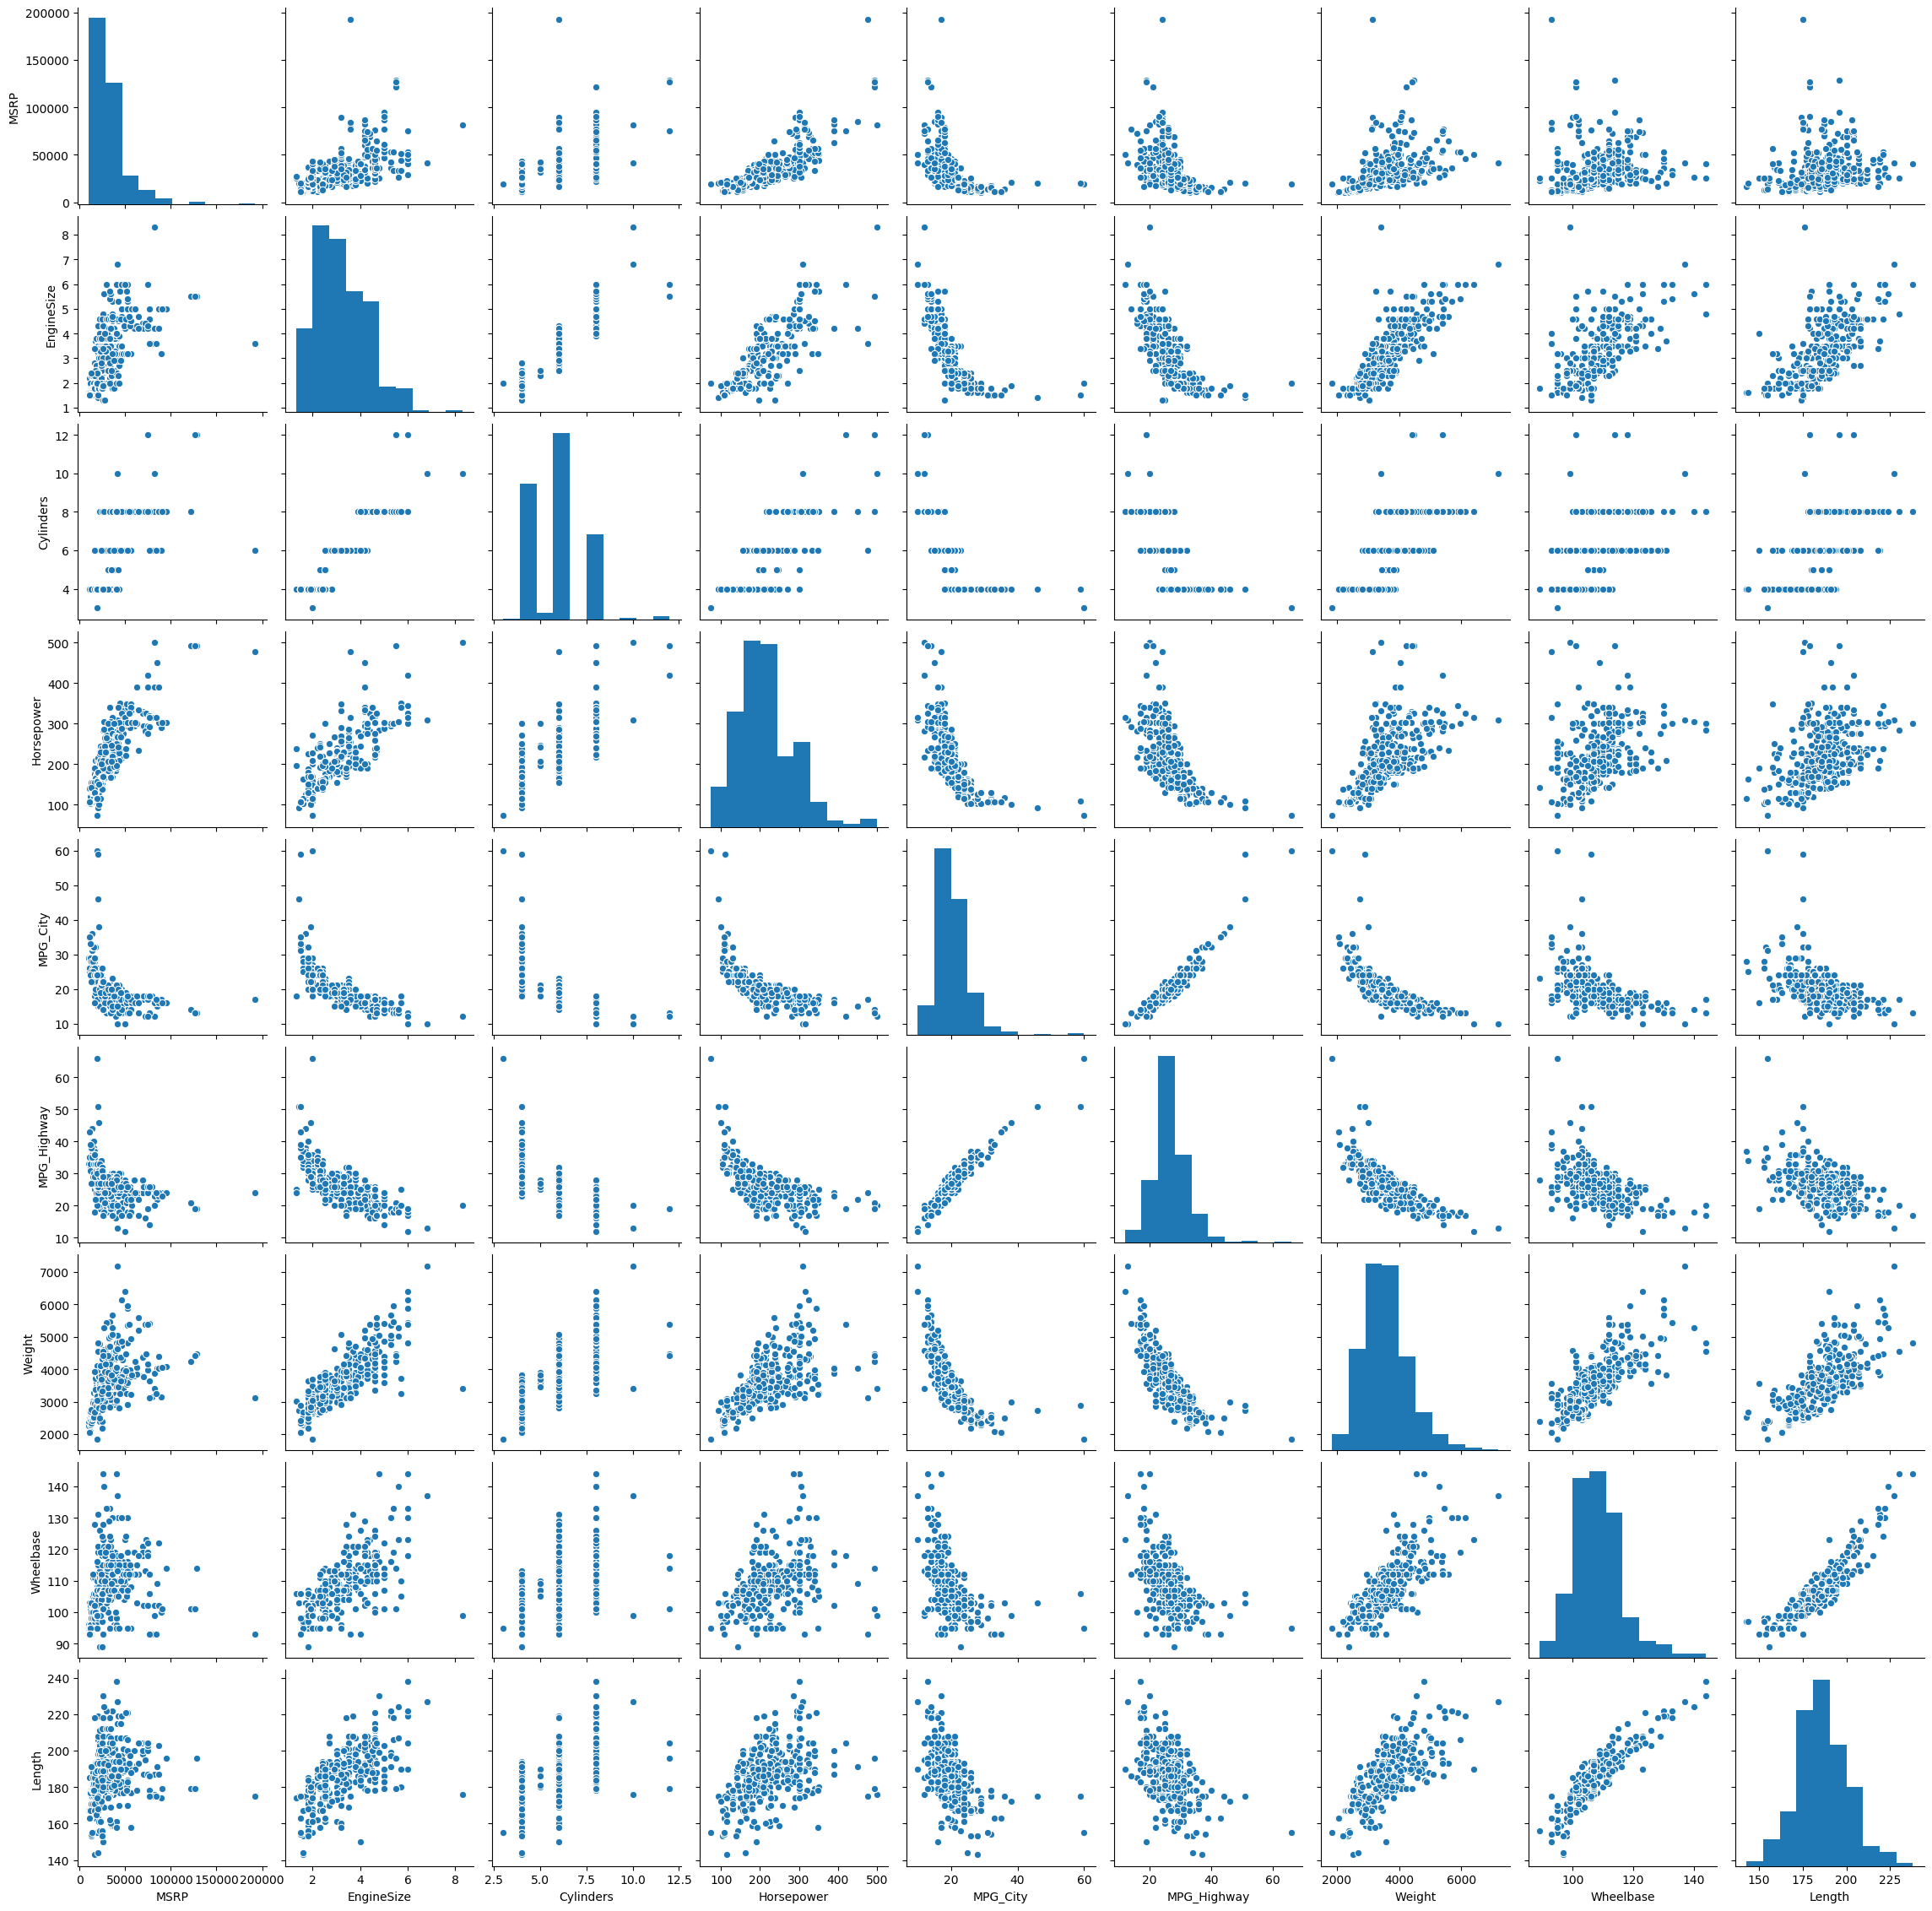

In [161]:
# generate pairplot for all car_df data
sns.pairplot(car_df);

In [162]:
# extract the numeric columns
X_numerical = car_df[['EngineSize', 'Cylinders', 'Horsepower', 'MPG_City', 
                       'MPG_Highway', 'Weight', 'Wheelbase', 'Length', 'MSRP']]

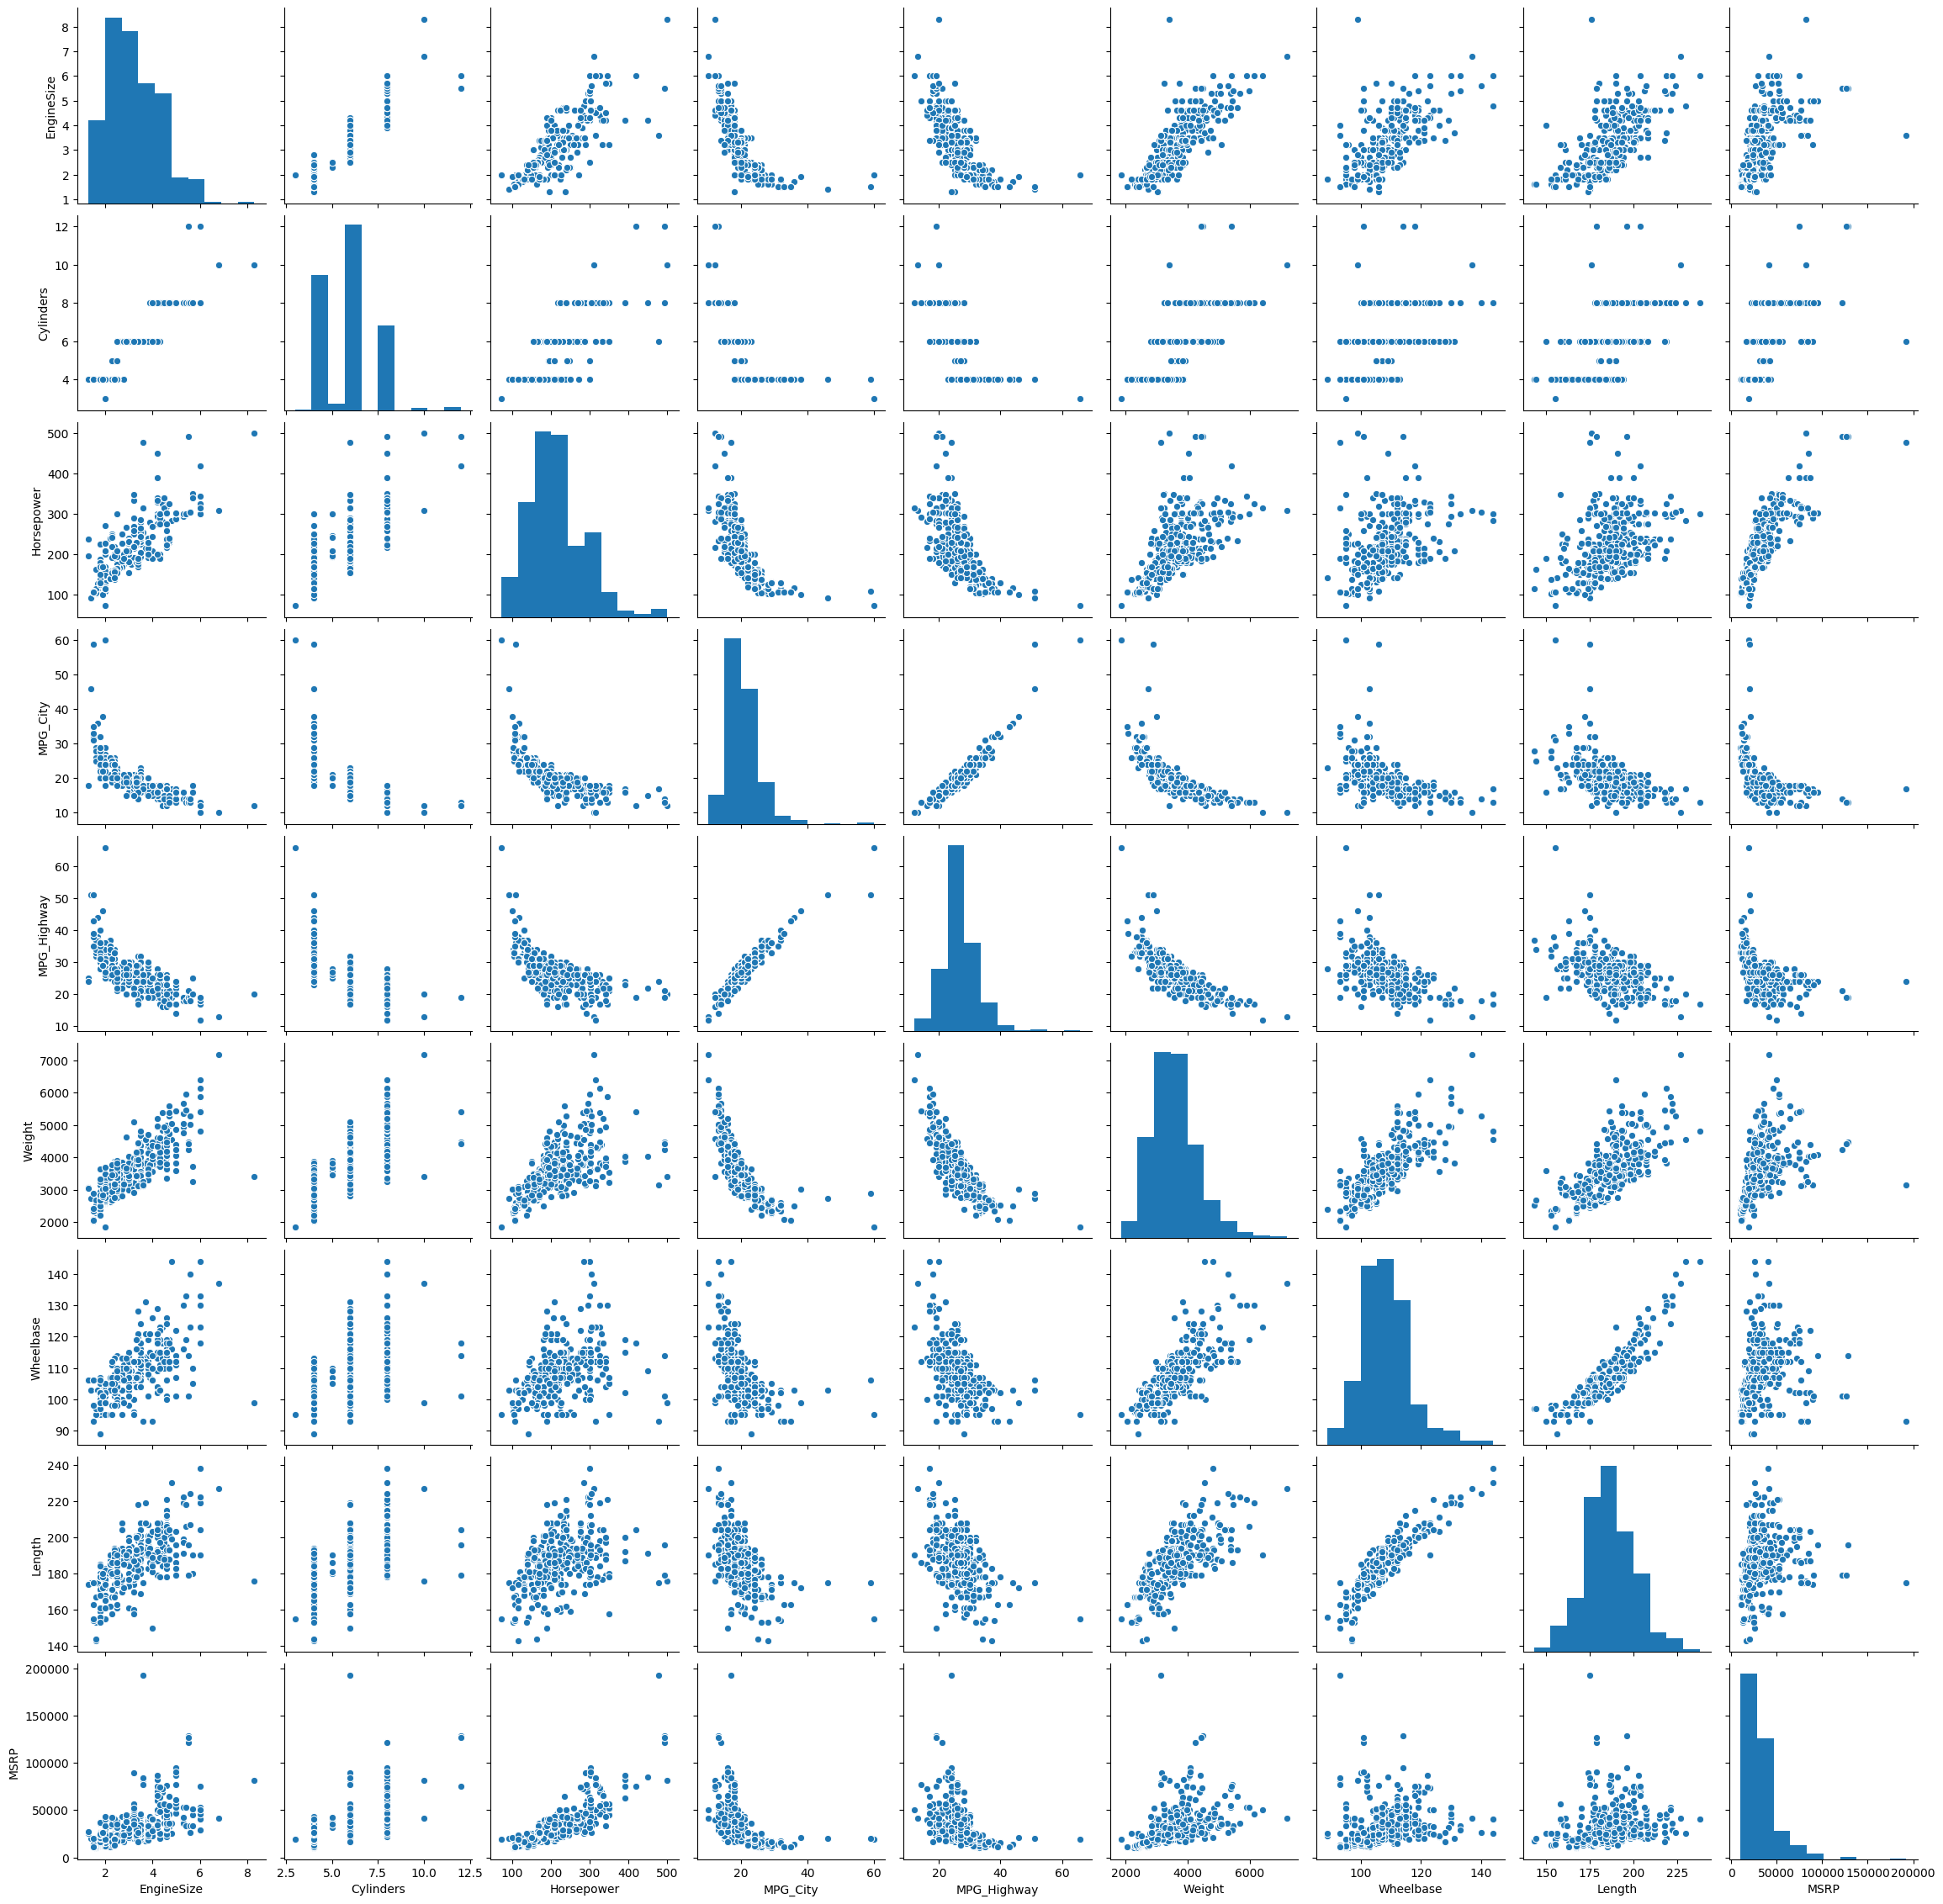

In [163]:
# generate pairplot for numeric values only
sns.pairplot(X_numerical);

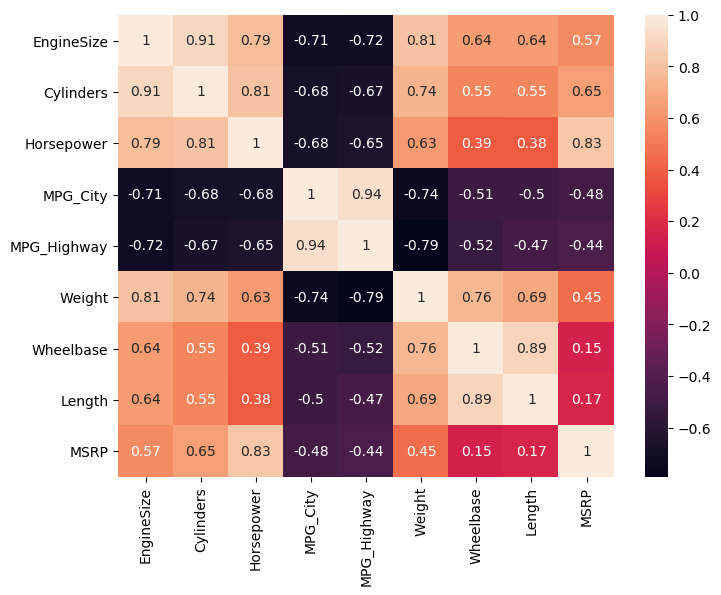

In [164]:
# generate a heatmap for numeric values
plt.figure(figsize = (8, 6))
sns.heatmap(X_numerical.corr(), annot = True);

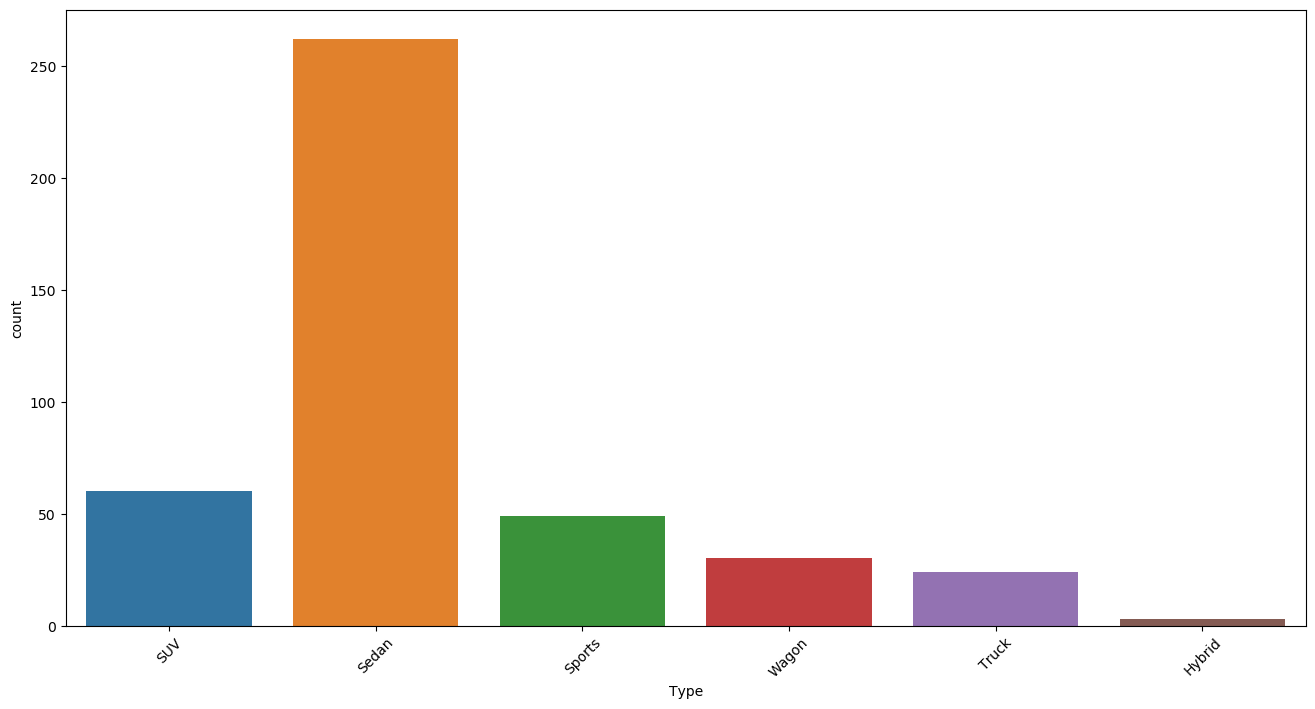

In [165]:
# generate a box plot for automobile types
plt.figure(figsize = (16, 8))
sns.countplot(x = car_df['Type'])
locs, labels = plt.xticks();
plt.setp(labels, rotation = 45);

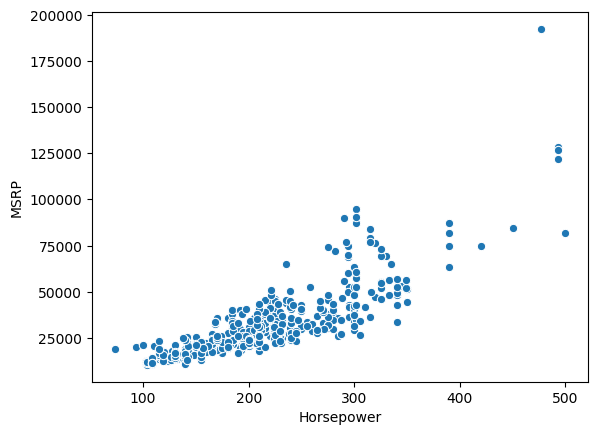

In [166]:
# generate a scatterplot for Horsepower and MSRP
sns.scatterplot(x = 'Horsepower', y = 'MSRP', data = car_df)

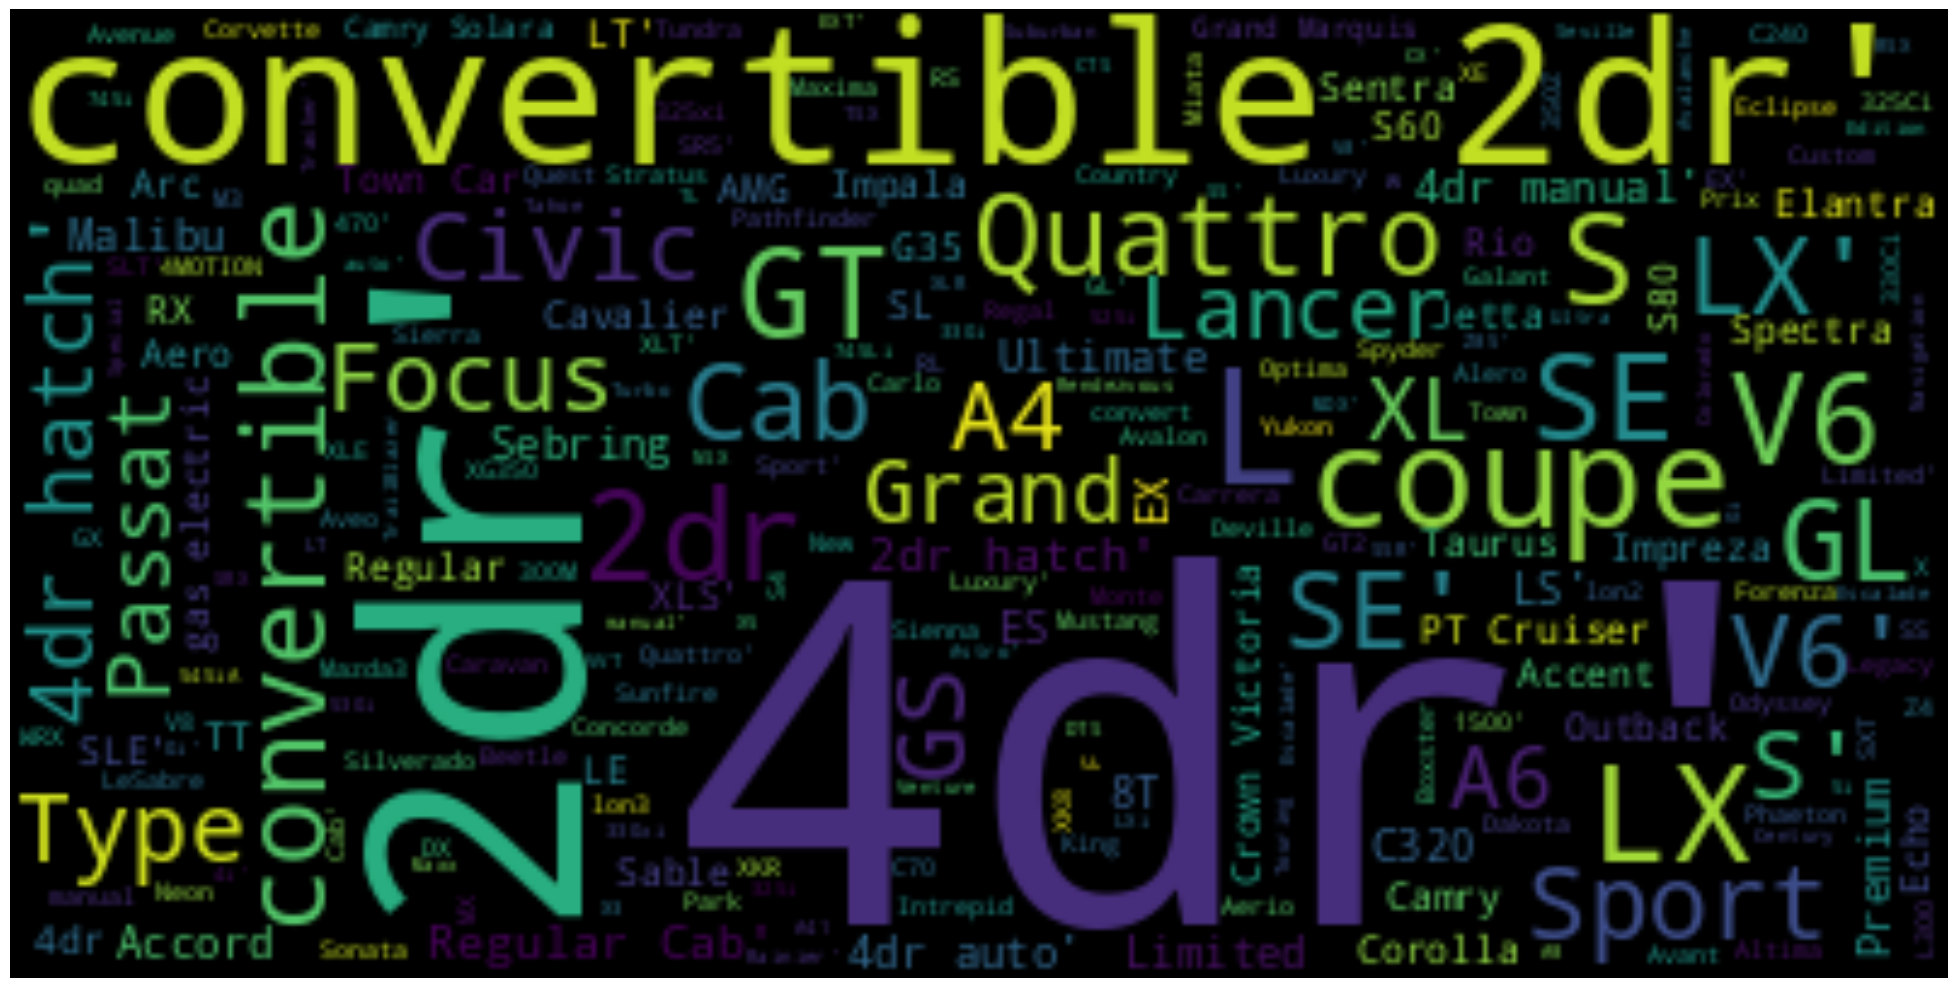

In [167]:
# generate a word cloud for automobile Model values
text = car_df.Model.values
stopwords = set(STOPWORDS)

wc = WordCloud(background_color = "black", max_words = 2000, max_font_size = 100, random_state = 3, 
              stopwords = stopwords, contour_width = 3).generate(str(text))

fig = plt.figure(figsize = (25, 15))
plt.imshow(wc, interpolation = "bilinear")
plt.axis("off")
plt.show()

## 4. Split the data into training, validation and testing datasets

In [168]:
# Perform One-Hot Encoding for columns with categorical data
car_df = pd.get_dummies(car_df, columns=["Make", "Model", "Type", "Origin", "DriveTrain"])
car_df.head(5)

,MSRP,EngineSize,Cylinders,Horsepower,MPG_City,MPG_Highway,Weight,Wheelbase,Length,Make_Acura,...,Type_Sedan,Type_Sports,Type_Truck,Type_Wagon,Origin_Asia,Origin_Europe,Origin_USA,DriveTrain_All,DriveTrain_Front,DriveTrain_Rear
0,36945,3.5,6,265,17,23,4451,106,189,1,...,0,0,0,0,1,0,0,1,0,0
1,23820,2.0,4,200,24,31,2778,101,172,1,...,1,0,0,0,1,0,0,0,1,0
2,26990,2.4,4,200,22,29,3230,105,183,1,...,1,0,0,0,1,0,0,0,1,0
3,33195,3.2,6,270,20,28,3575,108,186,1,...,1,0,0,0,1,0,0,0,1,0
4,43755,3.5,6,225,18,24,3880,115,197,1,...,1,0,0,0,1,0,0,0,1,0


In [169]:
# assign input features (independent variables) to X and output feature (dependent variable) to y
X = car_df.drop("MSRP", axis = 1)
y = car_df["MSRP"]

In [170]:
# X = np.array(X)
# y = np.array(y)

X = np.array(X).astype('float32')
y = np.array(y).astype('float32')

In [171]:
# view X shape
X.shape

(428, 483)

In [172]:
# view y shape
y.shape

(428,)

In [173]:
# split the data into train & testing sets (85% of data for training)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

# split test data set into test set & validation set (50% of test data will be used for validation)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5)

In [174]:
# view shape of training data independent variables
X_train.shape

(363, 483)

In [175]:
# view shape of test data independent variable
X_test.shape

(32, 483)

In [176]:
# view shape of test data independent variable
X_val.shape

(33, 483)

In [177]:
# view shape of training data dependent variable
y_train.shape

(363,)

## 5. Prepare the data for SageMaker

In [178]:
# convert the training & validation arrays into dataframes with the dependent variable set as the first column.
# this is because sagemaker built-in algorithm expects the data in this format.

train_data = pd.DataFrame({'Target': y_train})
for i in range(X_train.shape[1]):
    train_data[i] = X_train[:,i]
    
val_data = pd.DataFrame({'Target':y_val})
for i in range(X_val.shape[1]):
    val_data[i] = X_val[:,i]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  # Remove the CWD from sys.path while we load stuff.


In [179]:
# view validation data
val_data.head(5)

,Target,0,1,2,3,4,5,6,7,8,...,473,474,475,476,477,478,479,480,481,482
0,32415.0,3.0,6.0,215.0,18.0,24.0,3285.0,105.0,177.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,49995.0,6.0,8.0,316.0,10.0,12.0,6400.0,123.0,190.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,21595.0,3.0,6.0,155.0,20.0,27.0,3308.0,109.0,200.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,10539.0,1.6,4.0,103.0,29.0,33.0,2255.0,96.0,167.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,36100.0,5.3,8.0,295.0,14.0,18.0,5678.0,130.0,222.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [180]:
# view train_data
train_data.head(5)

,Target,0,1,2,3,4,5,6,7,8,...,473,474,475,476,477,478,479,480,481,482
0,29995.0,2.5,6.0,192.0,18.0,26.0,3428.0,107.0,184.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,25045.0,2.0,4.0,227.0,20.0,27.0,3085.0,99.0,174.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,20220.0,2.4,4.0,150.0,21.0,28.0,3175.0,108.0,191.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,22035.0,2.7,6.0,200.0,21.0,29.0,3469.0,113.0,204.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,17163.0,2.5,6.0,165.0,19.0,22.0,3020.0,98.0,163.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [181]:
# save train_data and validation_data as csv files.
train_data.to_csv('train.csv', header = False, index = False)
val_data.to_csv('validation.csv', header = False, index = False)

## 6. Train an XG-Boost model using SageMaker

In [182]:
# create a Sagemaker session
sagemaker_session = sagemaker.Session()
bucket = Session().default_bucket() 
prefix = 'XGBoost-Regressor'
key = 'XGBoost-Regressor'

# declare role to give learning and hosting access to the data
role = sagemaker.get_execution_role()

In [183]:
# upload the training data csv to the s3 bucket
with open('train.csv','rb') as f:
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(f)

s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

uploaded training data location: s3://sagemaker-us-east-1-628298263648/XGBoost-Regressor/train/XGBoost-Regressor


In [184]:
# upload the training data csv to the s3 bucket
with open('validation.csv','rb') as f:
    boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation', key)).upload_fileobj(f)

s3_validation_data = 's3://{}/{}/validation/{}'.format(bucket, prefix, key)
print('uploaded validation data location: {}'.format(s3_validation_data))

uploaded validation data location: s3://sagemaker-us-east-1-628298263648/XGBoost-Regressor/validation/XGBoost-Regressor


In [185]:
# creates output placeholder in S3 bucket to store the trained model
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('training artifacts will be uploaded to: {}'.format(output_location))

training artifacts will be uploaded to: s3://sagemaker-us-east-1-628298263648/XGBoost-Regressor/output


In [186]:
# create a reference to the XGBoost container image
container = sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, version='1.0-1')

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


In [187]:
# create a SageMaker XGBoost regressor
regressor = sagemaker.estimator.Estimator(container,
                                       role, 
                                       instance_count = 1, 
                                       instance_type = 'ml.m4.xlarge',
                                       output_path = output_location,
                                       sagemaker_session = sagemaker_session)

In [188]:
# set the regressor hyperparameters
regressor.set_hyperparameters(max_depth = 2,
                           objective = 'reg:squarederror',
                           colsample_bytree = 0.3,
                           alpha = 0.1,
                           eta = 0.8,
                           num_round = 100)

In [189]:
# define the regressor data channels (training and validation data)
train_input = sagemaker.session.TrainingInput(s3_data = s3_train_data, content_type = 'csv',s3_data_type = 'S3Prefix')
valid_input = sagemaker.session.TrainingInput(s3_data = s3_validation_data, content_type = 'csv',s3_data_type = 'S3Prefix')

data_channels = {'train': train_input,'validation': valid_input}

In [190]:
# train the data model using the data channels
regressor.fit(data_channels)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-07-12-04-41-16-919


2023-07-12 04:41:17 Starting - Starting the training job...
2023-07-12 04:41:41 Starting - Preparing the instances for training.........
2023-07-12 04:42:50 Downloading - Downloading input data...
2023-07-12 04:43:20 Training - Downloading the training image...
2023-07-12 04:44:06 Training - Training image download completed. Training in progress...[2023-07-12 04:44:22.806 ip-10-0-126-189.ec2.internal:7 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determine

## 7. Deploy the unoptimised model and obtain KPI's

In [191]:
# deploy the model
predictor = regressor.deploy(initial_instance_count = 1, instance_type = "ml.m4.xlarge")

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-07-12-04-44-59-841
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-07-12-04-44-59-841
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-07-12-04-44-59-841


-------!

In [192]:
# obtain predictions for test data
predictor.serializer = CSVSerializer()
predictions = predictor.predict(X_test)
predictions

b'29380.958984375,32496.431640625,13725.9501953125,23666.615234375,16972.994140625,26912.982421875,26309.08203125,26398.7109375,21943.90234375,31553.564453125,16337.021484375,16972.994140625,33116.05078125,44037.2109375,21785.392578125,13725.9501953125,97984.78125,30746.869140625,22088.958984375,38233.84375,37346.73046875,23325.234375,20753.84765625,34956.23046875,42303.8984375,16972.994140625,13610.57421875,23774.564453125,78457.2109375,25270.17578125,38336.52734375,20738.1953125'

In [193]:
# convert the values in bytes format to array
def bytes_2_array(x):
    l = str(x).split(',')
    l[0] = l[0][2:]
    l[-1] = l[-1][:-1]
    for i in range(len(l)):
        l[i] = float(l[i])
    l = np.array(l).astype('float32')
    return l.reshape(-1,1)
    
predicted_values = bytes_2_array(predictions)
predicted_values

array([[29380.959],
       [32496.432],
       [13725.95 ],
       [23666.615],
       [16972.994],
       [26912.982],
       [26309.082],
       [26398.71 ],
       [21943.902],
       [31553.564],
       [16337.021],
       [16972.994],
       [33116.05 ],
       [44037.21 ],
       [21785.393],
       [13725.95 ],
       [97984.78 ],
       [30746.87 ],
       [22088.959],
       [38233.844],
       [37346.73 ],
       [23325.234],
       [20753.848],
       [34956.23 ],
       [42303.9  ],
       [16972.994],
       [13610.574],
       [23774.564],
       [78457.21 ],
       [25270.176],
       [38336.527],
       [20738.195]], dtype=float32)

In [194]:
# collect KPI metrics by comparing predicted_values for test data to actual y_test values
k = X_test.shape[1]
n = len(X_test)
RMSE = float(format(np.sqrt(mean_squared_error(y_test, predicted_values)),'.3f'))
MSE = mean_squared_error(y_test, predicted_values)
MAE = mean_absolute_error(y_test, predicted_values)
r2 = r2_score(y_test, predicted_values)
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)

print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2) 

RMSE = 5220.492 
MSE = 27253538.0 
MAE = 3267.0022 
R2 = 0.9364099860293775 
Adjusted R2 = 1.004361262020109


In [195]:
# Delete the endpoint
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-xgboost-2023-07-12-04-44-59-841
INFO:sagemaker:Deleting endpoint with name: sagemaker-xgboost-2023-07-12-04-44-59-841


## 8. Perform Hyperparameter Tuning

In [196]:
regressor = sagemaker.estimator.Estimator(container,
                                       role, 
                                       instance_count = 1, 
                                       instance_type = 'ml.m4.xlarge',
                                       input_mode = 'File',
                                       use_spot_instances = True, 
                                       max_run = 300,
                                       max_wait = 600,
                                       output_path = output_location,
                                       sagemaker_session = sagemaker_session)

regressor.set_hyperparameters(objective = 'reg:linear',
                                      early_stopping_rounds = 10,
                                      num_round = 150)

regressor

In [197]:
# defiine hyperparameter ranges 
hyperparameter_ranges = {'eta': ContinuousParameter(0.3, 1),
                         'alpha': ContinuousParameter(0.1, 0.4),
                         'max_depth': IntegerParameter(8, 15)}
hyperparameter_ranges

{'eta': <sagemaker.parameter.ContinuousParameter at 0x7fb4eb14ff50>,
 'alpha': <sagemaker.parameter.ContinuousParameter at 0x7fb4eb14ff90>,
 'max_depth': <sagemaker.parameter.IntegerParameter at 0x7fb4eb14f390>}

In [198]:
# create hyperparameters tuning job

tuner = HyperparameterTuner(regressor,
                            objective_metric_name = 'validation:rmse',
                            hyperparameter_ranges = hyperparameter_ranges,
                            objective_type =  'Minimize', 
                            max_jobs = 5,
                            max_parallel_jobs = 1)
tuner

In [199]:
# run tuning job
tuner.fit(data_channels)

INFO:sagemaker:Creating hyperparameter tuning job with name: sagemaker-xgboost-230712-0449


.................................................................................................................................................................................................................................................................!


In [200]:
# view hyperparameter output for tuning job (the 'latest' ie. best configuration identified)
summary = HyperparameterTuningJobAnalytics(sagemaker_session = sagemaker_session,
                                       hyperparameter_tuning_job_name = tuner.latest_tuning_job.name).dataframe()
summary

,alpha,eta,max_depth,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,0.388265,0.623155,8.0,sagemaker-xgboost-230712-0449-005-f1dacc09,Completed,4786.978027,2023-07-12 05:08:56+00:00,2023-07-12 05:10:48+00:00,112.0
1,0.272014,0.631030,8.0,sagemaker-xgboost-230712-0449-004-48d506c6,Completed,4534.644043,2023-07-12 05:04:54+00:00,2023-07-12 05:06:46+00:00,112.0
2,0.166181,0.340352,15.0,sagemaker-xgboost-230712-0449-003-e1105a7d,Completed,4374.461914,2023-07-12 04:58:52+00:00,2023-07-12 05:00:39+00:00,107.0
3,0.297940,0.599598,13.0,sagemaker-xgboost-230712-0449-002-749d0328,Completed,3404.736084,2023-07-12 04:54:44+00:00,2023-07-12 04:56:36+00:00,112.0
4,0.210109,0.904200,11.0,sagemaker-xgboost-230712-0449-001-bddad2de,Completed,6130.155762,2023-07-12 04:50:43+00:00,2023-07-12 04:52:35+00:00,112.0


## 9. Deploy the optimised model and obtain KPI's

In [201]:
# deploy the best model after conducting the hyperparameters tuning job
predictor = tuner.deploy(initial_instance_count = 1, instance_type = "ml.m4.xlarge")


2023-07-12 04:56:36 Starting - Preparing the instances for training
2023-07-12 04:56:36 Downloading - Downloading input data
2023-07-12 04:56:36 Training - Training image download completed. Training in progress.
2023-07-12 04:56:36 Uploading - Uploading generated training model
2023-07-12 04:56:36 Completed - Training job completed

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-07-12-05-11-10-095


INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-230712-0449-002-749d0328
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-230712-0449-002-749d0328


--------!

In [202]:
# obtain predictions for test data
predictor.serializer = CSVSerializer()
predictions = predictor.predict(X_test)
predictions

b'34032.72265625,31580.109375,11508.255859375,25243.3515625,19214.154296875,25387.94921875,30698.2578125,27807.458984375,25387.94921875,26328.3671875,19214.154296875,15356.6298828125,29849.06640625,45507.7265625,21479.681640625,11508.255859375,130988.34375,32051.541015625,19522.494140625,40379.48046875,35880.30859375,23644.939453125,21501.56640625,29237.32421875,46282.82421875,19214.154296875,16456.95703125,22176.21875,76415.90625,23881.291015625,38966.16015625,20294.609375'

In [203]:
# convert the values in bytes format to array
def bytes_2_array(x):
    l = str(x).split(',')
    l[0] = l[0][2:]
    l[-1] = l[-1][:-1]
    for i in range(len(l)):
        l[i] = float(l[i])
    l = np.array(l).astype('float32')
    return l.reshape(-1,1)
    
predicted_values = bytes_2_array(predictions)
predicted_values

array([[ 34032.723],
       [ 31580.11 ],
       [ 11508.256],
       [ 25243.352],
       [ 19214.154],
       [ 25387.95 ],
       [ 30698.258],
       [ 27807.459],
       [ 25387.95 ],
       [ 26328.367],
       [ 19214.154],
       [ 15356.63 ],
       [ 29849.066],
       [ 45507.727],
       [ 21479.682],
       [ 11508.256],
       [130988.34 ],
       [ 32051.541],
       [ 19522.494],
       [ 40379.48 ],
       [ 35880.31 ],
       [ 23644.94 ],
       [ 21501.566],
       [ 29237.324],
       [ 46282.824],
       [ 19214.154],
       [ 16456.957],
       [ 22176.219],
       [ 76415.91 ],
       [ 23881.291],
       [ 38966.16 ],
       [ 20294.61 ]], dtype=float32)

In [204]:
# collect KPI metrics by comparing predicted_values for test data to actual y_test values
k = X_test.shape[1]
n = len(X_test)
RMSE = float(format(np.sqrt(mean_squared_error(y_test, predicted_values)),'.3f'))
MSE = mean_squared_error(y_test, predicted_values)
MAE = mean_absolute_error(y_test, predicted_values)
r2 = r2_score(y_test, predicted_values)
adj_r2 = 1-(1-r2)*(n-1)/(n-k-1)

print('RMSE =',RMSE, '\nMSE =',MSE, '\nMAE =',MAE, '\nR2 =', r2, '\nAdjusted R2 =', adj_r2) 

RMSE = 3314.265 
MSE = 10984354.0 
MAE = 2467.288 
R2 = 0.974370474635362 
Adjusted R2 = 1.001757777182088


In [205]:
# Delete the endpoint
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-xgboost-230712-0449-002-749d0328
INFO:sagemaker:Deleting endpoint with name: sagemaker-xgboost-230712-0449-002-749d0328
